# Rydberg Blockade Radius

In this notebook we will use Pulser to simulate a sequence of succesive $\pi$-pulses on a two atom system, each one coupling the atom to its excited Rydberg state. We will vary the interatomic distance and observe where do we begin to observe a strong *Rydberg Blockade* effect. This effect is due to the presence of a van der Waals interaction when both atoms are in the Rydberg state, and prevents the collective ground state $|gg\rangle$ to couple to $|rr\rangle$, which is shifted out of resonance. More details can be found in [2002.07413](https://arxiv.org/pdf/2002.07413) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

In [2]:
from pulser import Pulse, Sequence, Register, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform

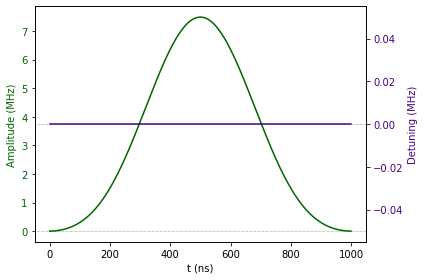

In [3]:
duration = 1000 # Typical: ~1 µsec
pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0., 0)
pi_pulse.draw()

The pulse that we created will act as a $\frac{\hbar \Omega_i(t)}{2} \sigma_i^x$ term in the effective Hamiltonian of our system, for $i$ labelling any of the atoms. In addition, we express the shift in energy from the van der Waals interaction between the atoms $1$ and $2$ as $U n_1n_2$, where $n_i = |r\rangle \langle r|_i$ and $U = C_6/R^6$. The constant $C_6$ depends on the specific chosen Rydberg level, which in our case is predetermined in the Pasqal device ($C_6/\hbar \approx 5008$ GHz.$\mu m^6$). Our effective Hamiltonian is then:

$$H = \frac{\hbar \Omega_1(t)}{2} \sigma_1^x + \frac{\hbar \Omega_2(t)}{2} \sigma_2^x + U n_1n_2 $$

We impose the blockade condition as $\hbar \Omega_{max} \ll U$ and solve for $R = R_{\text{blockade}}$ obtaining:

In [4]:
Omega_max = np.max(pi_pulse.amplitude.samples)
R_blockade = Chadoq2.rydberg_blockade_radius(Omega_max)
print(R_blockade)

9.351877348654495


We shall define a register of two atoms, for several distances $R$:

In [6]:
data = []
divisions = 7
distances = np.linspace(6.5,14,divisions)

r = [1,0]
rr = np.kron(r,r) # |rr>
occup = [np.outer(rr, np.conj(rr))]  # |rr><rr|

for i,R in enumerate(distances):
    print(f'{divisions-i} remaining...')
    # Atom Register and Device
    reg = Register.rectangle(1,2,spacing=R, prefix='atom')
    #reg.draw()

    # Pulse Sequence
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ryd','rydberg_local','atom0')
    seq.declare_channel('ryd2','rydberg_local2','atom1')
    seq.add(pi_pulse,'ryd')
    seq.align('ryd','ryd2')
    seq.add(pi_pulse,'ryd2')
    #seq.draw()

    sim = Simulation(seq)
    plt.show()
    
    res = sim.run()
    data.append(res.expect(occup)[0])

7 remaining...


AttributeError: 'SimulationResults' object has no attribute 'output'

We plot the results

In [ ]:
for i,R in enumerate(distances):
    plt.plot(res[i], label=f'R={R}')
    plt.xlabel('Time (ns)', fontsize=14)
    plt.ylabel(r'Occupation of $|rr\rangle$', fontsize=14)
    plt.legend()

Notice how the occupation of $|rr\rangle$ is suppressed for decreasing $R$, in particular below our estimated Rydberg blockade radius, $R \lesssim 9.35\mu m$. Once the interatomic distance grows, the excited Rydberg state $|rr\rangle$ becomes populated again: the blockade effect is lost.